<a href="https://colab.research.google.com/github/conextm/python/blob/main/example_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchviz


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [2]:

# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hazing-images-dataset-cvpr-2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1458957%2F2411813%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T035421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4c3aa214c204b8a629cebcfc79f9bf3140c04663c044a5bdf0a125c80e32519d2c19e4e041a43b4c4edc7da81c4355fbaa48ee15fa45eacf17b65d62c1c0a1a8b68b7a08183c6fb5188ae3c5be5b3d9fa27788827260f00ba32016982facaf5307889a419dd05dc305a2a290be5a3721d5ad6710025b08efbf29732be18e9f222935f6ba07f3cfc299e4e33442897b6e4acf5cad1190efbe5b5f726c93f50f6d75056b61373c82d531f0f20ddb3c8e84320c92eae4733ec766f791992d6ba9a7c1cb78f680021031bf32d9e83af1088e4de93dd53b7eb446c35034c92afbde4a97cd26a208a1c0e81d966aa8d60ba726846c5dfa92f1bd010e5cd8bdc37d7d24'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 245701500 bytes downloaded
Downloaded and uncompressed: hazing-images-dataset-cvpr-2019
Data source import complete.


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cuda


In [5]:
torch.cuda.empty_cache()

## Dataset: Dense-Haze
El conjunto de datos Dense-Haze contiene 55 pares de imágenes con y sin neblina. Se utiliza como referencia para tareas de eliminación de neblina en imágenes.

Referencia: https://data.vision.ee.ethz.ch/cvl/ntire19//dense-haze/

### Data Processing

Creamos matrices numpy para las imágenes brumosas y no brumosas reduciendo el tamaño de la imagen para realizar cálculos y entrenamientos más rápidos.

También nos aseguramos de que las imágenes se concatenan en el mismo orden para crear pares de imágenes (nebulosas y no nebulosas).

In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm

class dehazer():

    def __init__(self, IMG_SIZE, LABEL_DIR, LABEL_NAME):
        """
        Constructor method for the dehazer class.

        Args:
            IMG_SIZE (int): Size to which the images will be resized.
            LABEL_DIR (str): Directory containing the images.
            LABEL_NAME (str): Name prefix of the images.
        """
        self.IMG_SIZE = IMG_SIZE
        self.LABEL_DIR = LABEL_DIR
        self.LABEL_NAME = LABEL_NAME

        self.training_data = []  # Initialize an empty list to store training data

    def make_training_data(self):
        """
        Method to create training data by reading and resizing images.
        """
        NUM_IMAGES = len(os.listdir(self.LABEL_DIR))  # Get the number of images in the directory

        # Iterate over each image file in the directory
        for f in tqdm(range(1, NUM_IMAGES+1)):
            # Format the filename using the image number and label name
            f = "{:02d}".format(f) + '_' + self.LABEL_NAME + '.png'
            # Construct the full path to the image file
            path = os.path.join(self.LABEL_DIR, f)
            # Read the image from the file
            img = cv2.imread(path)
            # Resize the image to the specified size
            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
            # Convert the resized image to a NumPy array and append it to the training data list
            self.training_data.append(np.array(img))



        np.save(f'{self.LABEL_NAME}.npy',self.training_data)

In [7]:
REBUILD_DATA=True

# Set the size of the images to 256x256 pixels
IMG_SIZE = 256

# Define the directory containing the ground truth images
gt_dir = '../input/hazing-images-dataset-cvpr-2019/GT'

# Define the directory containing the hazy images
hazy_dir = '../input/hazing-images-dataset-cvpr-2019/hazy'

# Check if we need to rebuild the training data
if (REBUILD_DATA):
    # Create an instance of the 'dehazer' class for ground truth images
    dehazing = dehazer(IMG_SIZE, gt_dir, 'GT')

    # Generate training data for ground truth images
    dehazing.make_training_data()

    # Create another instance of the 'dehazer' class for hazy images
    dehazing = dehazer(IMG_SIZE, hazy_dir, 'hazy')

    # Generate training data for hazy images
    dehazing.make_training_data()



100%|██████████| 55/55 [00:04<00:00, 11.10it/s]


In [8]:
# Load the ground truth images from the 'GT.npy' file into the 'patch' variable
patch = np.load('GT.npy', allow_pickle=True)

# Load the hazy images from the 'hazy.npy' file into the 'mask' variable
mask = np.load('hazy.npy', allow_pickle=True)

# Check the length of the 'patch' and 'mask' arrays
len(patch), len(mask)

(55, 55)

In [9]:
patch.shape, mask.shape

((55, 256, 256, 3), (55, 256, 256, 3))

### Visualizing Data
visualizamos algunas imagenes .

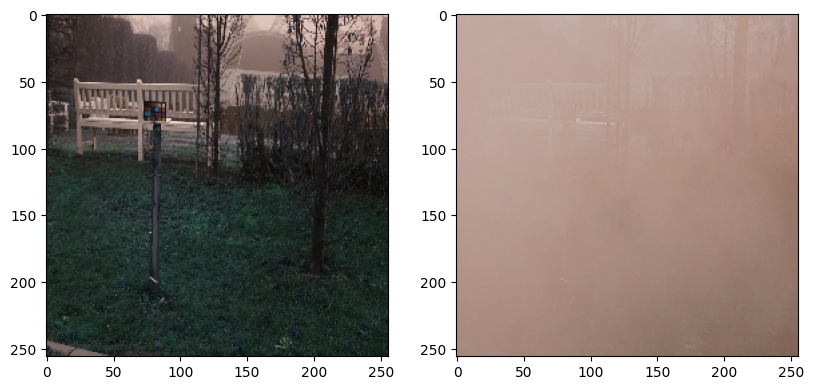

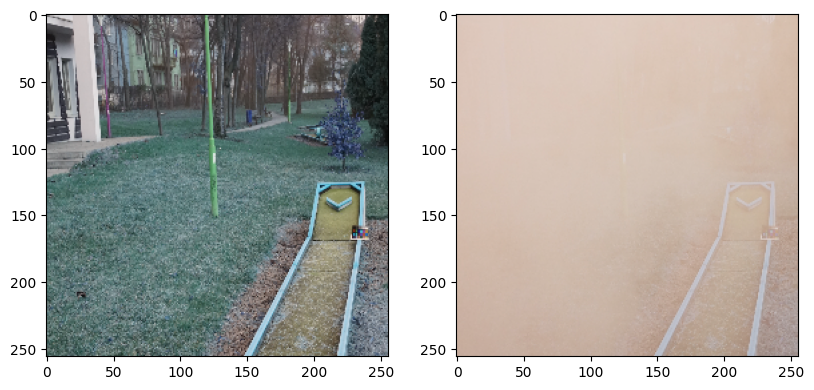

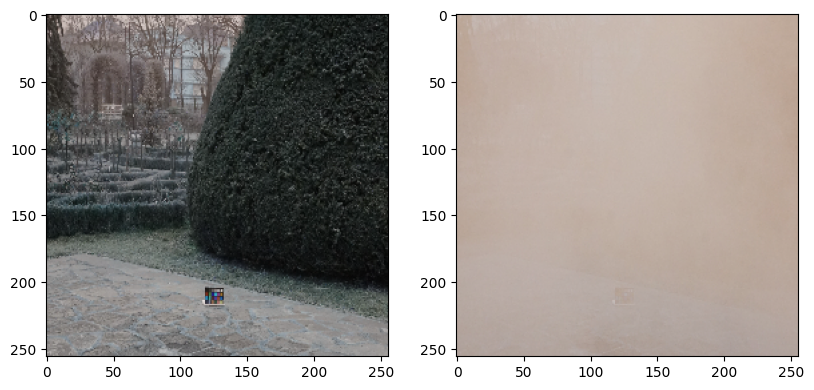

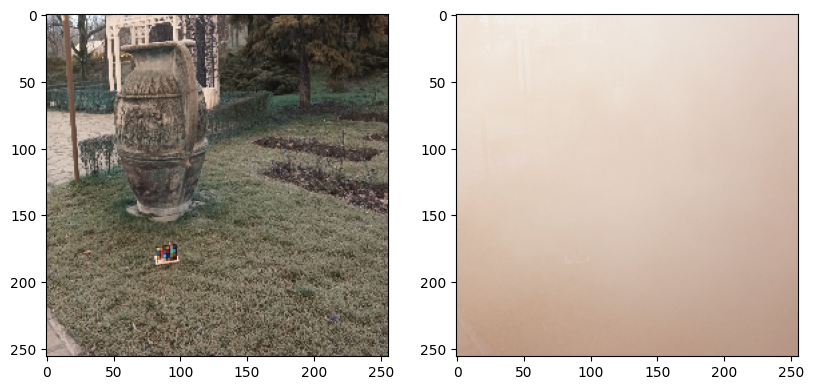

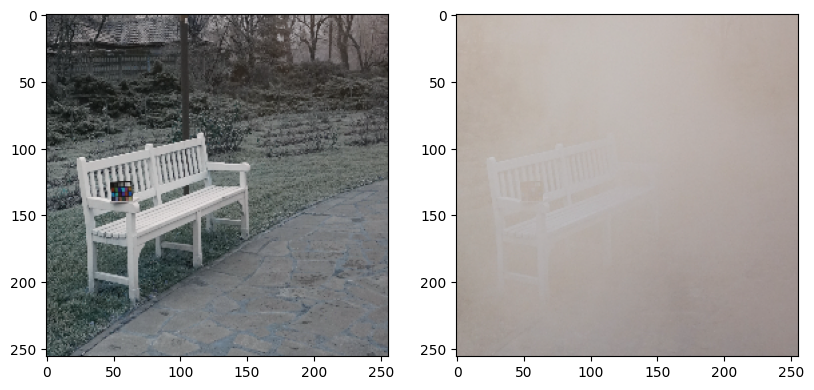

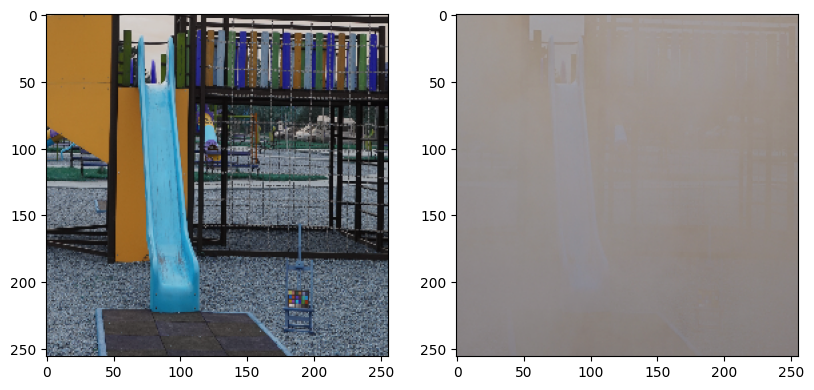

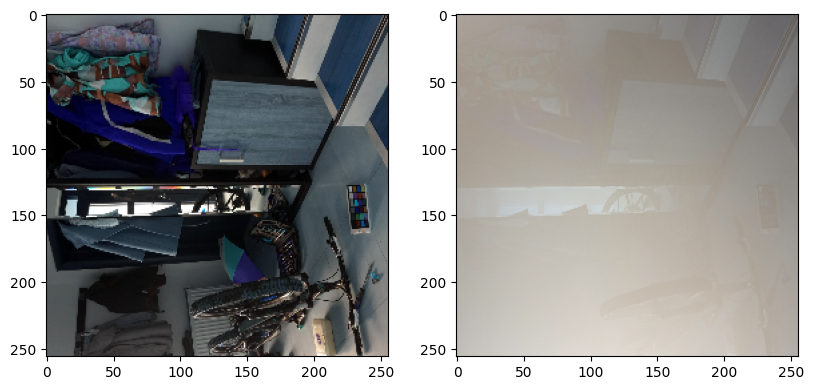

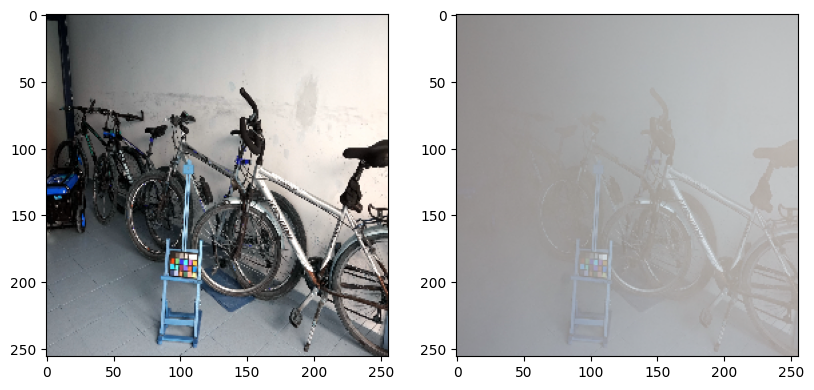

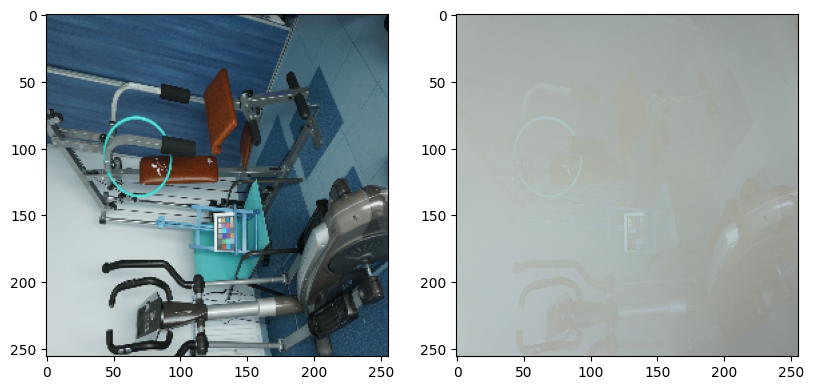

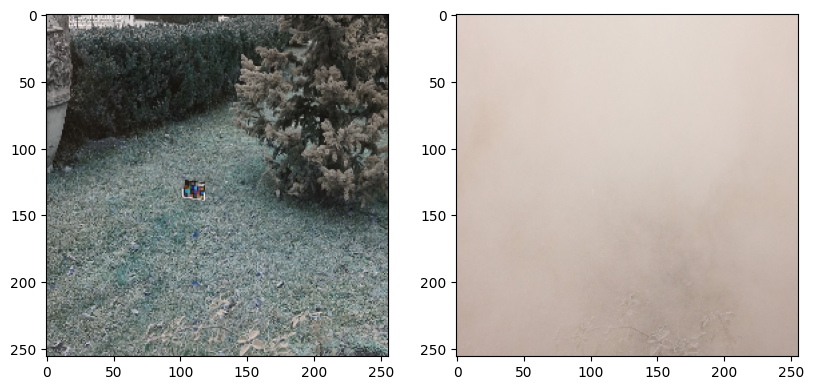

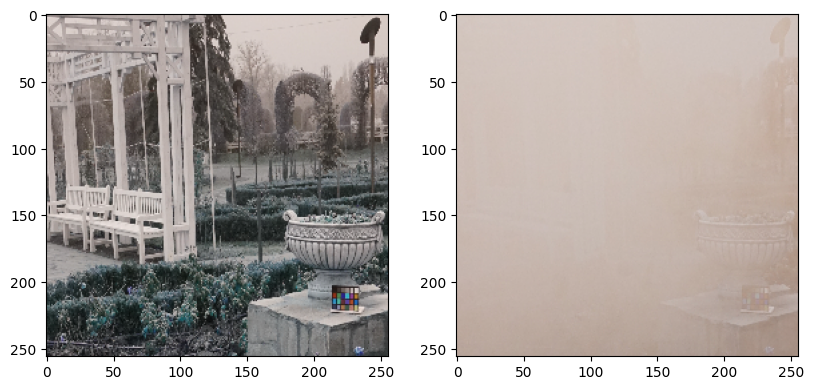

In [10]:
for i in range(0,len(patch),5):

    fig=plt.figure(figsize=(15, 5))

    ax = plt.subplot(131)
    plt.imshow(patch[i])

    ax = plt.subplot(132)
    plt.imshow(mask[i])
    plt.show()

Como el número de imágenes es bastante reducido (55 en total), lo entrenaremos con los datos completos.

Como el número de imágenes es menor, entrenaremos manteniendo un tamaño de lote de 1, es decir, **Descenso Gradiente Estocástico**. El aprendizaje puede ser ruidoso y puede llevar más tiempo. Por lo tanto, mantendremos la tasa de aprendizaje bastante baja y la entrenaremos con un número suficientemente grande de épocas.


### MODEL HYPERPARAMETERS

In [36]:
IMG_SIZE = 256

EPOCHS = 150
batch_size = 1
learning_rate = 0.005

In [37]:
# Create a DataLoader for the 'patch' dataset with the specified batch size and without shuffling
patch_loader = torch.utils.data.DataLoader(dataset=patch, batch_size=batch_size, shuffle=False)

# Iterate over the DataLoader to retrieve batches of data
for data in patch_loader:
    # Print the size of the batch data
    print(data.size())
    # Print the type of the data
    print(type(data))
    # Break the loop after processing the first batch
    break

torch.Size([1, 256, 256, 3])
<class 'torch.Tensor'>


In [38]:
# Create a tensor for the original patch dataset by iterating over the 'patch' list and converting it to a tensor
X_orig = torch.Tensor([patch[i] for i in range(len(patch))])

# Create a tensor for the hazy mask dataset by iterating over the 'mask' list and converting it to a tensor
X_hazy = torch.Tensor([mask[i] for i in range(len(mask))])

# Normalize the original patch dataset by dividing by 255
X_orig = X_orig / 255

# Normalize the hazy mask dataset by dividing by 255
X_hazy = X_hazy / 255

In [39]:
# Print the size of the X_orig tensor
print('X_orig: ', X_orig.size())

# Transpose the X_orig tensor to have the channel dimension as the second dimension
X_orig_T = np.transpose(X_orig, (0, 3, 1, 2))
X_hazy_T=np.transpose(X_hazy,(0,3,1,2))
# Print the shape of the transposed X_orig tensor
print('X_orig_T: ', X_orig_T.shape)

# Reshape the transposed X_orig tensor to have a single channel
X_orig_flat = X_orig_T.reshape(-1, 1, IMG_SIZE, IMG_SIZE)

# Reshape the transposed X_hazy tensor to have a single channel
X_hazy_flat = X_hazy_T.reshape(-1, 1, IMG_SIZE, IMG_SIZE)

# Print the shape of the flattened X_orig tensor
print('X_orig_flat: ', X_orig_flat.shape)

X_orig:  torch.Size([55, 256, 256, 3])
X_orig_T:  torch.Size([55, 3, 256, 256])
X_orig_flat:  torch.Size([165, 1, 256, 256])


### Model Architecture: Encoder-Decoder


Piensa en la diferencia básica entre el aprendizaje automático y el aprendizaje profundo. En el primero, es el científico de datos/el creador del modelo quien construye las características que luego se pasan al modelo. Sin embargo, en el segundo, delegamos la tarea de crear características también a la máquina además de aprender los patrones en los datos.

Entonces, básicamente, cualquier problema de aprendizaje profundo se puede pensar ampliamente como:

<code>Entrada (Tabular, Imagen, Texto, etc.) -> Codificador para convertir la entrada en representaciones numéricas -> Aprendizaje -> Predicción -> Decodificador para convertir las predicciones a la forma original -> Salida (Tabular, Imagen, Texto, etc.)</code>

Sin embargo, es posible que haya algunos pasos que no estén involucrados en el pipeline anterior. Por ejemplo, si tus datos son puramente numéricos, es posible que no tengas que codificarlos y decodificarlos, pero para la entrada no estructurada como imágenes, texto u otros, tendrás que hacerlo. Esta es la idea básica detrás de la Arquitectura Codificador-Decodificador.

Considera un problema de traducción automática de traducir oraciones del inglés al francés. Aquí, la función del codificador mapea el espacio de entrada (texto en inglés) a un espacio latente, seguido por una función de decodificación que mapea el espacio latente a un espacio de destino diferente (texto en francés).

En nuestro caso, el espacio de entrada son imágenes con niebla y el espacio de salida son imágenes no borrosas/referencia.

In [40]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

encoder = Encoder().cuda()

In [41]:
from torchsummary import summary

summary(encoder, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
       BatchNorm2d-3         [-1, 32, 256, 256]              64
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
       BatchNorm2d-6         [-1, 32, 256, 256]              64
            Conv2d-7         [-1, 64, 256, 256]          18,496
              ReLU-8         [-1, 64, 256, 256]               0
       BatchNorm2d-9         [-1, 64, 256, 256]             128
           Conv2d-10         [-1, 64, 256, 256]          36,928
             ReLU-11         [-1, 64, 256, 256]               0
      BatchNorm2d-12         [-1, 64, 256, 256]             128
        MaxPool2d-13         [-1, 64, 128, 128]               0
           Conv2d-14        [-1, 128, 1

In [42]:
from torchviz import make_dot

example_input = torch.randn(1, 1, 256, 256).cuda()

# Obtener el gráfico de la red
graph = make_dot(encoder(example_input), params=dict(encoder.named_parameters()))

# Guardar el gráfico como imagen
graph.render("encoder_graph")

'encoder_graph.pdf'

In [43]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )

    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [44]:
# Check output of encoder-decoder

train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_flat,batch_size=batch_size,shuffle=False)
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
    orig_image = Variable(train_orig).cuda()
    hazy_image = Variable(train_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    print('Image Dim: ',orig_image.size())
    print('Hazy Image Dim: ',hazy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([1, 1, 256, 256])
Hazy Image Dim:  torch.Size([1, 1, 256, 256])
Encoder Output Dim:  torch.Size([1, 1048576])
Output Dim:  torch.Size([1, 1, 256, 256])


### Loss function and Optimizer
**Función de pérdida:** Pérdida de error cuadrático medio (MSE)

Dado que nuestro objetivo es minimizar la diferencia entre la salida del decodificador (imagen desdibujada) y la verdad sobre el terreno, tratamos de minimizar el MSE entre dos imágenes.
    
**Optimizador**: Adam (Adaptive Moment Estimation), comúnmente visto como combinación de Adagrad y Momentum.

1. 1. Tasa de aprendizaje adaptativa para distintos parámetros
2. Convergencia más rápida mediante Momentum, lo que da lugar a gradientes acelerados
    

In [ ]:
# In order to use multi parameters with one optimizer, concat parameters after changing into list
# Combinar los parámetros del codificador y el decodificador en una lista para el optimizador
parameters = list(encoder.parameters()) + list(decoder.parameters())

# Definir la función de pérdida como Mean Squared Error (MSE)
loss_func = nn.MSELoss()

# Definir el optimizador Adam para actualizar los parámetros de la red neuronal
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

# Lista para almacenar las pérdidas en cada iteración
losses = []

# Copiar el conjunto original de imágenes para no modificar los datos originales
X_orig1 = X_orig

# Iterar sobre el número de épocas especificado
for epoch in tqdm(range(EPOCHS)):

    # Barajar los índices de las imágenes originales
    rand_idx = torch.randperm(X_orig1.size()[0])

    # Obtener las imágenes originales y borrosas reorganizadas aleatoriamente
    X_orig_iter = X_orig[rand_idx]
    X_hazy_iter = X_hazy[rand_idx]

    # Transponer y remodelar las imágenes para que tengan la forma correcta
    X_orig_iter1 = np.transpose(X_orig_iter, (0, 3, 1, 2))
    X_hazy_iter1 = np.transpose(X_hazy_iter, (0, 3, 1, 2))
    X_orig_iter2 = X_orig_iter1.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
    X_hazy_iter2 = X_hazy_iter1.reshape(-1, 1, IMG_SIZE, IMG_SIZE)

    # Crear DataLoader para las imágenes originales y borrosas
    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter2, batch_size=batch_size, shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter2, batch_size=batch_size, shuffle=False)

    # Iterar sobre los lotes de imágenes originales y borrosas
    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()

        # Reiniciar los gradientes
        optimizer.zero_grad()

        # Pasar la imagen borrosa a través del codificador y el decodificador
        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)

        # Calcular la pérdida entre la imagen original y la imagen reconstruida
        loss = loss_func(output, orig_image)

        # Propagar hacia atrás y actualizar los parámetros
        loss.backward()
        optimizer.step()

    # Registrar la pérdida para esta época
    losses.append(loss)

# Guardar el modelo entrenado como un archivo .pkl
torch.save([encoder, decoder], 'dehaze_autoencoder.pkl')


  9%|▊         | 13/150 [00:59<10:18,  4.52s/it]

In [ ]:
losses_cpu = [loss.cpu().detach() for loss in losses]
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(losses_cpu)
plt.show()

In [ ]:
encoder, decoder = torch.load('dehaze_autoencoder.pkl')

In [ ]:
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for train_hazy in tqdm(train_hazy_loader):
    hazy_image = Variable(train_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

In [ ]:
# Apilar los elementos de dehazed_output para formar un tensor
X_dehazed = dehazed_output
X_dehazed = torch.stack(X_dehazed)

# Imprimir el tamaño del tensor resultante
print(X_dehazed.size())

# Cambiar la forma del tensor para que tenga dimensiones (batch_size, 1, 256, 256)
X_dehazed = X_dehazed.view(-1, 1, 256, 256)

# Imprimir la nueva forma del tensor
print(X_dehazed.size())

# Cambiar nuevamente la forma del tensor para que tenga dimensiones (batch_size, 3, 256, 256)
X_dehazed = X_dehazed.view(-1, 3, 256, 256)

# Imprimir la nueva forma del tensor
print(X_dehazed.size())

# Permutar las dimensiones del tensor para que tengan el orden (batch_size, 256, 256, 3)
X_dehazed = X_dehazed.permute(0, 2, 3, 1)

# Imprimir la forma resultante del tensor
print(X_dehazed.shape)


In [ ]:
for i in range(0,len(X_orig),10):

    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])

    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(X_hazy[i])

    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

### EVALUATION METRICS

### PSNR (Peak signal-to-noise ratio)

Es una expresión para la relación entre la máxima potencia posible de una señal y la potencia del ruido corruptor que afecta a la fidelidad de su representación. Suele expresarse en términos de escala logarítmica de decibelios, debido a su amplio rango dinámico. No tiene rango. **Cuanto más alto sea, mejor.

### Structural Similarity (SSIM) Index.
El SSIM se utiliza para medir la similitud entre dos imágenes. El índice SSIM es un método para predecir la calidad percibida de imágenes de televisión digital y cine, así como de otros tipos de imágenes y vídeos digitales. Es una métrica de referencia completa, lo que significa que la medición o predicción de la calidad de la imagen se basa
en una imagen inicial sin comprimir o sin distorsiones como referencia. Oscila entre -1 y 1 y el SSIM es igual a 1 sólo cuando las imágenes son idénticas. **Cuanto más se acerque a 1, mejor.

In [ ]:
X_dehazed=X_dehazed.numpy()
X_orig=X_orig.numpy()

X_orig=X_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_orig
res_mat=X_dehazed

print(ref_mat.shape)
print(res_mat.shape)

In [ ]:
ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def mean_psnr_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_psnr = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        psnr = output_psnr_mse(ref_block, res_block)
        mean_psnr += psnr
    return mean_psnr / n_blk

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

In [ ]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_ssim = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        ssim1 = ssim(ref_block, res_block, gaussian_weights=True, use_sample_covariance=False,
                     multichannel=True)
        mean_ssim += ssim1
    return mean_ssim / n_blk

# SSIM
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)